In [5]:
# Initialize plotting:
%matplotlib inline
# Import all relevant packages
import PIL
from PIL import Image
import scipy.ndimage
import numpy as np, matplotlib.pyplot as plt
import scipy.stats
import scipy as sp
from ipywidgets import interact
from scipy.integrate import solve_ivp

from importlib import reload
from IPython.display import clear_output, display

# Suppress some logging messages in Pillow (Python Imaging Library)
import logging; logging.getLogger('PIL').setLevel(logging.ERROR)  # Suppress PIL messages


## The Problem



Given some data $d$ obtained by adding noise to an original image $u_0$, how can we best approximate $u$?  In this assignment, we will explore approximations $u_\lambda$ obtained from the minimization problem

\begin{gather}
  \min_{u} E[u], \qquad
  \underbrace{E[u]}_{\text{energy}} = \underbrace{\int |\nabla u|^2}_{\text{regularization}} + \lambda \underbrace{\int |u-d|^2}_{\text{data fidelity}},\\
  d = u + \eta, \qquad
  \eta \sim \mathcal{N}(0, \sigma),
\end{gather}

where $\eta$ is (approximately) gaussian noise with standard deviation $\eta$.

We call $E[u]$ the "energy", and in the following, normalize it by $E[d]$ so that the noisy image has energy $E[d]=1$.



In [6]:
import denoise

sigma = 0.4
lam = 0.1
lam = 1/(2*sigma)
im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam)


u_exact = im.get_data(sigma=0)
u_noise = im.get_data(sigma=sigma)
u = d.minimize(callback=None)
E_u = d.get_energy(u)
E_noise = d.get_energy(u_noise)
E_exact = d.get_energy(u_exact)

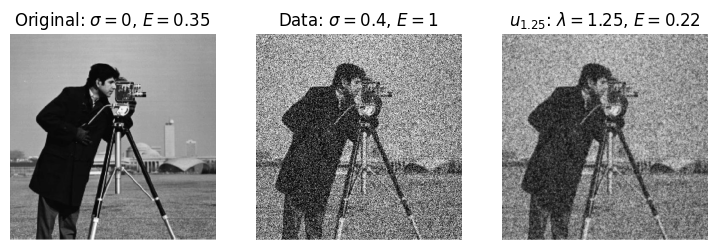

In [7]:
fig, axs = denoise.subplots(3)
for _u, title, ax in [(u_exact, rf"Original: $\sigma=0$, $E={E_exact:.2g}$", axs[0]),
                     (u_noise, rf"Data: $\sigma={sigma}$, $E={E_noise:.2g}$", axs[1]),
                     (u, rf"$u_{{{lam}}}$: $\lambda={lam}$, $E={E_u:.2g}$", axs[2])]:
    im.show(_u, ax=ax)
    ax.set(title=title);

## Fourier Techniques

Text(0.5, 1.0, 'Error')

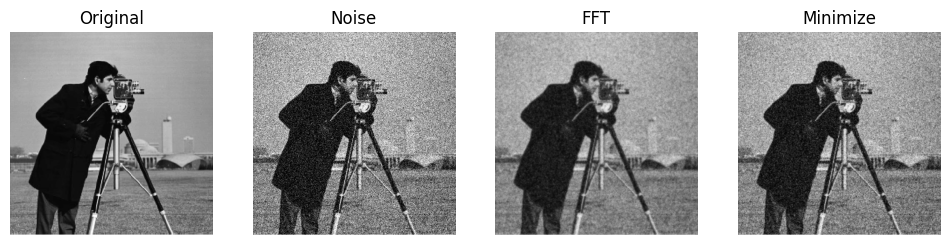

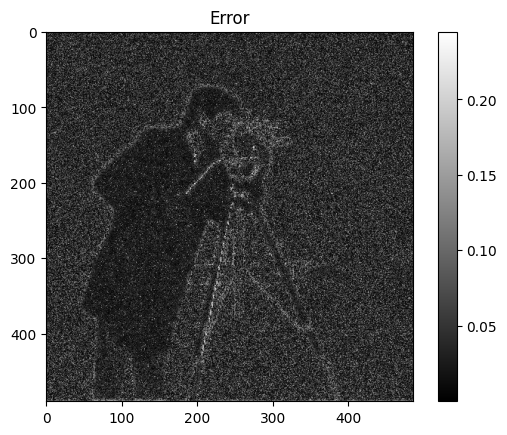

In [8]:
import denoise

sigma = 0.2
lam = 1/2/sigma

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="wrap")

Nx, Ny = im.shape

dx = dy = .5
x = (np.arange(Nx) * dx)[:, None]
y = (np.arange(Ny) * dy)[None, :]
kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)[:, None]
ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)[None, :]

fft, ifft = np.fft.fftn, np.fft.ifftn

u = ifft(lam * fft(d.u_noise) / (lam + (kx**2 + ky**2)))
assert np.allclose(u.imag, 0)
u_fft = u.real
u_solve = d.minimize(d.u_noise)

clear_output()
data = [
    ("Original", d.u_exact),
    ("Noise", d.u_noise),
    ("FFT", u_fft),
    ("Minimize", u_solve),
]
fig, axs = denoise.subplots(len(data))
for ax, (title, u) in zip(axs, data):
    im.show(u, ax=ax)
    ax.set(title=title)

plt.figure()
plt.imshow(abs(u_solve - u_fft));
plt.colorbar()
plt.title("Error")